In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import sys, os, time, csv, cv2

# Settings
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.5f}'.format
np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(precision = 5, suppress = True)

In [2]:
attack_train = pd.read_csv('/Users/ryan/NSL CNN/2d-cnn/datasets/60-40/attack_train_6040.csv')
normal_train = pd.read_csv('/Users/ryan/NSL CNN/2d-cnn/datasets/60-40/normal_train_6040.csv')
attack_test = pd.read_csv('/Users/ryan/NSL CNN/2d-cnn/datasets/60-40/attack_test_6040.csv')
normal_test = pd.read_csv('/Users/ryan/NSL CNN/2d-cnn/datasets/60-40/normal_test_6040.csv')

In [3]:
attack_train

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,icmp,tcp,udp,IRC,X11,Z39_50,auth,bgp,courier,csnet_ns,ctf,daytime,discard,domain,domain_u,echo,eco_i,ecr_i,efs,exec,finger,ftp,ftp_data,gopher,hostnames,http,http_443,imap4,iso_tsap,klogin,kshell,ldap,link,login,mtp,name,netbios_dgm,netbios_ns,netbios_ssn,netstat,nnsp,nntp,ntp_u,other,pm_dump,pop_2,pop_3,private,remote_job,shell,smtp,sql_net,ssh,sunrpc,supdup,systat,telnet,tftp_u,tim_i,time,urp_i,uucp,uucp_path,vmnet,whois,OTH,REJ,RSTO,RSTOS0,RSTR,S0,S1,S2,S3,SF,SH,attack_type
0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,128.24853,7.48532,255.00000,255.00000,0.00000,0.00000,15.30000,15.30000,0.00000,255.00000,17.00000,17.85000,15.30000,0.00000,0.00000,255.00000,255.00000,0.00000,0.00000,0.00000,255.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,255.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,255.00000,0.00000,0.00000,0.00000,0.00000,0.00000,attack
1,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,93.31703,2.49511,252.45000,255.00000,2.55000,0.00000,7.65000,20.40000,0.00000,255.00000,5.00000,5.10000,20.40000,0.00000,0.00000,255.00000,255.00000,0.00000,0.00000,0.00000,255.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,255.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,255.00000,0.00000,0.00000,0.00000,0.00000,0.00000,attack
2,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,75.35225,1.99609,255.00000,255.00000,0.00000,0.00000,7.65000,15.30000,0.00000,255.00000,4.00000,5.10000,12.75000,0.00000,0.00000,255.00000,255.00000,0.00000,0.00000,0.00000,255.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,255.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,255.00000,0.00000,0.00000,0.00000,0.00000,0.00000,attack
3,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0

In [4]:
dataframes = [attack_train, normal_train, attack_test, normal_test]
for df in dataframes:
    df.drop(df.columns[df.columns.str.contains('attack_type')], 1, inplace=True)

In [5]:
attack_train = attack_train.to_numpy()
normal_train = normal_train.to_numpy()
attack_test = attack_test.to_numpy()
normal_test = normal_test.to_numpy()

attack_train = np.ravel(attack_train, order = 'F')
normal_train = np.ravel(normal_train, order = 'F')
attack_test = np.ravel(attack_test, order = 'F')
normal_test = np.ravel(normal_train, order = 'F')

print(f'Attack train shape: {attack_train.shape}\nNormal train shape: {normal_train.shape}')
print(f'Attack test shape: {attack_test.shape}\nNormal test shape: {normal_test.shape}')

Attack train shape: (4839870,)
Normal train shape: (5263266,)
Attack test shape: (3226656,)
Normal test shape: (5263266,)


## Adding padding

In [6]:
train_attack_padding = -attack_train.size % 4096
train_normal_padding = -normal_train.size % 4096

if train_attack_padding:
    attack_train = np.concatenate((attack_train, np.zeros(train_attack_padding, dtype = attack_train.dtype)))

if train_normal_padding:
    normal_train = np.concatenate((normal_train, np.zeros(train_normal_padding, dtype = normal_train.dtype)))


In [7]:
test_attack_padding = -attack_test.size % 4096
test_normal_padding = -normal_test.size % 4096

if test_attack_padding:
    attack_test = np.concatenate((attack_test, np.zeros(test_attack_padding, dtype = attack_test.dtype)))

if test_normal_padding:
    normal_test = np.concatenate((normal_test, np.zeros(test_normal_padding, dtype = normal_test.dtype)))

In [8]:
attack_train = attack_train.reshape(-1, 64, 64, 1)
normal_train = normal_train.reshape(-1, 64, 64, 1)
attack_test = attack_test.reshape(-1, 64, 64, 1)
normal_test = normal_test.reshape(-1, 64, 64, 1)

print(f'Attack train shape: {attack_train.shape}\nNormal train shape: {normal_train.shape}')
print(f'Attack test shape: {attack_test.shape}\nNormal test shape: {normal_test.shape}')

Attack train shape: (1182, 64, 64, 1)
Normal train shape: (1285, 64, 64, 1)
Attack test shape: (788, 64, 64, 1)
Normal test shape: (1285, 64, 64, 1)


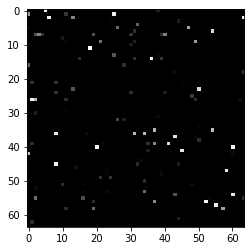

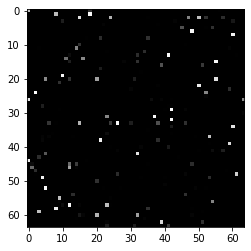

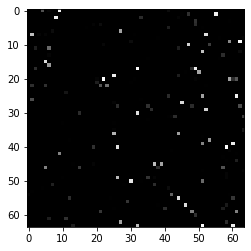

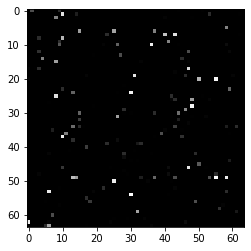

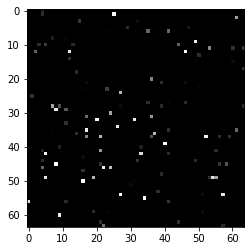

In [9]:
for t in range(0, 5):
    plt.imshow(attack_train[t], cmap = 'gray')
    plt.show()
    
    # cv2.imwrite(CUR_DIR + f'/image_before_equ_{t}.jpg', normal_imgs_tr[t])

## Creating the images

In [12]:
!pwd

/Users/ryan/NSL CNN/2d-cnn/split_images/train_normal


In [29]:
os.chdir('/Users/ryan/NSL CNN/2d-cnn/split_images/test_normal')
path = '/Users/ryan/NSL CNN/2d-cnn/split_images/test_normal'

In [30]:
## create the before images
for t in range(0, len(normal_test)):
#     plt.imshow(normal_imgs[t], cmap = 'gray')
#     plt.show()
    
    cv2.imwrite(os.path.join(path, f'test_normal_before_{t}.jpg'), normal_test[t])
#     cv2.imwrite(f'image_before_{t}.bmp', normal_imgs[t])

In [31]:
## loop through the before images, perform equalisation and save images to same directory
## ensure CWD is the directory saving the images to

for file in os.listdir(path):
    for i in range(0, normal_test.shape[0]):
        pre_equ = cv2.imread(f'test_normal_before_{i}.jpg', 0)
        # print(file)
        equalised = cv2.equalizeHist(pre_equ)
        cv2.imwrite(f'test_normal_equ_{i}.jpg', equalised)

KeyboardInterrupt: 